# MoireCNN

## 导入各种库

In [ ]:
import gzip, struct
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import math

torch.cuda.set_device(4)
#上面这一语句设定了默认调用的GPU编号，如果没有GPU…可以注释掉这一行，但是没有GPU真的能跑得动这个网络吗？

## 定义网络结构

In [ ]:
class MoireCNN(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.s11=nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, 1, 1)
        )
        self.s12=nn.Conv2d(32, 3, 3, 1, 1)
        
        self.s21=nn.Sequential(
            nn.Conv2d(32, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 1, 1)
        )
        self.s22=nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 3, 3, 1, 1)
        )
        
        self.s31=nn.Sequential(
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1)
        )
        self.s32=nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 3, 3, 1, 1)
        )
        
        self.s41=nn.Sequential(
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1)
        )
        self.s42=nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 3, 3, 1, 1)
        )
        
        self.s51=nn.Sequential(
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1)
        )
        self.s52=nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 3, 3, 1, 1)
        )
        
    def forward(self, x):
        x1=self.s11(x)
        x2=self.s21(x1)
        x3=self.s31(x2)
        x4=self.s41(x3)
        x5=self.s51(x4)
        
        x1=self.s12(x1)
        x2=self.s22(x2)
        x3=self.s32(x3)
        x4=self.s42(x4)
        x5=self.s52(x5)

        x=x1+x2+x3+x4+x5
        
        return torch.clamp(x, 0, 1)

## 实验数据清理

In [ ]:
from PIL import ImageFile
import os

ImPar=ImageFile.Parser()
M, N = 0, 0
rootPic1 = "/data_new/moire/trainData/source/"
rootPic2 = "/data_new/moire/trainData/target/"
picDir1 = [rootPic1+i for i in os.listdir(rootPic1)]
picDir2 = [rootPic2+i for i in os.listdir(rootPic2)]
picDir1.sort()
picDir2.sort()
cot = 0

print(len(picDir1), len(picDir2))

for i in range(len(picDir1)):
    with open(picDir1[i], "rb") as f:
        ImPar=ImageFile.Parser()
        chunk = f.read(2048)
        count=2048
        while chunk != "":
            ImPar.feed(chunk)
            if ImPar.image:
                break
            chunk = f.read(2048)
            count+=2048
        M, N = ImPar.image.size[0], ImPar.image.size[1]
    if M < 260 or N < 260:
        os.remove(picDir1[i])
        os.remove(picDir2[i])
        cot += 1

print("Done! Get %d rubbish." % cot)


## 定义train函数以及test函数

In [68]:
def train(epoch):

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)  

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

In [70]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

def test(idx):
    tf1=transforms.Compose([
        transforms.RandomCrop(256),
        transforms.ToTensor()
    ])

    tf2=transforms.ToPILImage()

    model.eval()
    root="/data_new/moire/testData/source/"
    testData=[root+i for i in os.listdir(root)]
    testData.sort()
    
    t = tf1(Image.open(testData[idx])).cuda()
    with torch.no_grad():
        y = model(t.unsqueeze(0)).squeeze().cpu()
    t = t.cpu()
    print(t.shape, y.shape)
    img = make_grid(list((t, y)))
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

## 定义读取数据集的类

In [60]:
import torch.utils.data as data
from torchvision import transforms
import os
from PIL import Image
from random import randint

class MoirePic(data.Dataset):
    def __init__(self, rootX, rootY, train=True):
        self.train=train
        self.picX=[rootX+i for i in os.listdir(rootX)]
        self.picY=[rootY+i for i in os.listdir(rootY)]
        self.picX.sort()
        self.picY.sort()
        self.picX=self.picX
        self.picY=self.picY
        
    def __getitem__(self, index):
        tf=transforms.ToTensor()

        def rand_crop(data,label):
            img_w, img_h = 256, 256

            width1 = randint(0, data.shape[1] - img_w )
            height1 = randint(0, data.shape[2] - img_h)
            width2 = width1 + img_w
            height2 = height1 + img_h 

            return (data[:,width1:width2,height1:height2],
            label[:,width1:width2,height1:height2])

        if self.train:
            pathX, pathY=self.picX[index], self.picY[index]
            imgX, imgY=Image.open(pathX), Image.open(pathY)
            return rand_crop(tf(imgX), tf(imgY))
    
    def __len__(self):
        return len(self.picX)

以下是test函数使用范例，就是用来肉眼观察对比model的效果的，用于粗略判断模型效果，毕竟摩尔纹方面没有什么好的指标可以评判视觉效果，而像MSE之流的量化指标有时候并不能很好地衡量，MSE相同的两张处理后的图片可能在视觉效果上有很大的出入。
左边是原图，右边是model处理后的图片。
test函数的输入值是index，也就是从测试集中抽取图片的下标，取值范围可以从0到十万多。

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


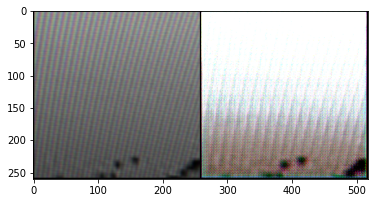

In [74]:
test(50)

下面进行了数据集加载等操作。其中重要的参数有batchsize和num_workers，具体可以自行调节，如果没有GPU就要设置pin_memory=False。

In [64]:
dataset=MoirePic("/data_new/moire/trainData/source/",
                "/data_new/moire/trainData/target/")
# dataset=MoirePic("/home/zhengjun/moire/moire-data/ValidationMoire/",
#                 "/home/zhengjun/moire/moire-data/ValidationClear/")
use_gpu = torch.cuda.is_available()
batch_size = 8
kwargs = {'num_workers': 14, 'pin_memory': True}     
train_loader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch_size, **kwargs)

In [66]:
#实例化网络
model = MoireCNN()

if use_gpu:
    model = model.cuda()
    # model = nn.DataParallel(model, device_ids=[3, 4, 5])
    #如果能够使用多卡跑模型的话，可以恢复上面这条语句，device_ids是允许调用的GPU编号列表。
    print('USE GPU')
else:
    print('USE CPU')

criterion = nn.MSELoss()
lr=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), weight_decay=0.00001)

USE GPU


In [69]:
for epoch in range(50):
    train(epoch)

torch.save(model, "moire-1.pth")

Train Epoch: 0 [0/100 (0%)]	Loss: 0.396826
Train Epoch: 1 [0/100 (0%)]	Loss: 0.215950
Train Epoch: 2 [0/100 (0%)]	Loss: 0.078023
Train Epoch: 3 [0/100 (0%)]	Loss: 0.097142
Train Epoch: 4 [0/100 (0%)]	Loss: 0.028610


In [4]:
import torch
#需要注意的是，在加载模型之前，必须确保模型所使用的网络结构没有变化，也就是MoireCNN类不变，因为在重建model的时候需要调用到对应的类
model = torch.load("moire-1.pth")
model.eval()

MoireCNN(
  (s11): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (s12): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (s21): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (s22): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (s31): Sequential(
    (0): Con